In [1]:
from functools import partial

import numpy as np
import pandas as pd
import scipy.odr as odr
import scipy.optimize as opt
import matplotlib.pyplot as plt
import uncertainties

In [2]:
# Universal constants
hbar = 6.582119569e-16 # eV * s
c = 299792458 # m/s
m_e = 511e3 / c**2 # eV / c^2


def ev_to_joule(e: float) -> float:
    # Convert energy from eV to Joules
    return e * 1.602176634e-19


def joule_to_ev(e: float) -> float:
    # Convert energy from joule to eV
    return e / 1.602176634e-19


def swap_ev_and_nm(v: float) -> float:
    # Convert an energy in eV to a wavelength in nm, and vice-versa
    return 1240 / v

In [3]:
def load_data_iflp(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename, sep='\t', header=1)
    df.columns = ['Wavelength', 'Absorbance']
    df['Wavelength unc'] = [0.1 for _ in df['Wavelength']]

    def abs_unc(abs: float) -> float:
        if abs <= 0.5: return 0.002
        elif abs <= 1: return 0.003
        elif abs <= 2: return 0.006
        else: return 0.003 / abs
    df['Absorbance unc'] = df['Absorbance'].apply(abs_unc)


    return df


def load_data_inifta(filename: str) -> pd.DataFrame:
    with open(filename, 'r') as f:
        # Find number of row that contains "#DATA"
        for i, line in enumerate(f):
            if line.startswith("#DATA"):
                data_start_row = i + 1
                break

    df = pd.read_csv(filename, sep='\t', skiprows=data_start_row)
    df.columns = ['Wavelength', 'Absorbance']
    df['Wavelength unc'] = [0.1 for _ in df['Wavelength']]

    def abs_unc(abs: float) -> float:
        if abs <= 0.5: return 0.002
        elif abs <= 1: return 0.003
        elif abs <= 2: return 0.006
        else: return 0.003 / abs
    df['Absorbance unc'] = df['Absorbance'].apply(abs_unc)


    return df.iloc[::-1].reset_index(drop=True)  # Reverse the dataframe to have increasing wavelength

In [4]:
def resonance(B: list[float], x: float) -> float:
    return B[0] * np.exp(-((x - B[1])**2) / (2 * B[2]**2))

def double_resonance(B: list[float], x: float) -> float:
    return resonance(B[0:3], x) + resonance(B[3:6], x) + B[6]
double_resonance_model = odr.Model(double_resonance)

class CnSpectrum:
    def __init__(self, name: str, filename: str, from_inifta: bool = False, x_range: tuple[float, float] | None = None):
        self.name = name
        self.df = load_data_iflp(filename) if not from_inifta else load_data_inifta(filename)
        self.fit_result: odr.Output | None = None
        self.x_range = x_range if x_range is not None else (self.df['Wavelength'].min(), self.df['Wavelength'].max())

    def fit(
            self, 
            x_range: tuple[float, float] | None = None, 
            initial_mu_d: float | None = None, 
            initial_sigma_d: float | None = None, 
            initial_a0_d: float | None = None,
            initial_mu_s: float | None = None, 
            initial_sigma_s: float | None = None,
            initial_a0_s: float | None = None,
            initial_y0: float | None = None,
            fix_y0: bool = False,
    ) -> odr.Output:
        if x_range is None: x_range = self.x_range

        x_data_mask = (self.df['Wavelength'] >= x_range[0]) & (self.df['Wavelength'] <= x_range[1])
        fit_data = odr.RealData(
            self.df['Wavelength'][x_data_mask], 
            self.df['Absorbance'][x_data_mask], 
            sx=self.df['Wavelength unc'][x_data_mask],
            sy=self.df['Absorbance unc'][x_data_mask],
        )


        if initial_mu_d is None:
            max_absorbance_index = self.df['Absorbance'].idxmax()
            initial_mu_d = self.df['Wavelength'].iloc[max_absorbance_index]
        if initial_sigma_d is None: initial_sigma_d = 50
        if initial_a0_d is None: initial_a0_d = self.df['Absorbance'].iloc[self.df['Wavelength'].searchsorted(initial_mu_d)]
        if initial_mu_s is None: initial_mu_s = initial_mu_d - 70
        if initial_sigma_s is None: initial_sigma_s = 80
        if initial_a0_s is None: initial_a0_s = self.df['Absorbance'].iloc[self.df['Wavelength'].searchsorted(initial_mu_s)]
        if initial_y0 is None: initial_y0 = 0
        initial_params = [
            initial_a0_d, initial_mu_d, initial_sigma_d, 
            initial_a0_s, initial_mu_s, initial_sigma_s, 
            initial_y0,
        ]

        # List of 0/1 to indicate which parameters are fixed (0) or free (1), following ODRPACK's convention
        fix_params = [1, 1, 1, 1, 1, 1, int(not fix_y0)]

        fit = odr.ODR(fit_data, double_resonance_model, beta0=initial_params, ifixb=fix_params)
        self.fit_result = fit.run()
        print(f'Fit stop: {self.fit_result.stopreason}')

        return self.fit_result

    @property
    def a0_d(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[0], self.fit_result.sd_beta[0])

    @property
    def mu_d(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[1], self.fit_result.sd_beta[1])

    @property
    def sigma_d(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[2], self.fit_result.sd_beta[2])

    @property
    def a0_s(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[3], self.fit_result.sd_beta[3])

    @property
    def mu_s(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[4], self.fit_result.sd_beta[4])

    @property
    def sigma_s(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[5], self.fit_result.sd_beta[5])

    @property
    def y_0(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[6], self.fit_result.sd_beta[6])

    def get_fit_params_df(self) -> pd.DataFrame | None:
        if self.fit_result is None: return None
        df = pd.DataFrame({
            'mu_d': [self.mu_d],
            'sigma_d': [self.sigma_d],
            'A_d': [self.a0_d],
            'mu_s': [self.mu_s],
            'sigma_s': [self.sigma_s],
            'A_s': [self.a0_s],
            'y_0': [self.y_0],
        })
        df.index = [self.name]
        return df

    def plot(self, mask: bool = False, x_range: tuple[float, float] | None = None, save: str | None = None):
        if mask or x_range:
            if not x_range: x_range = self.x_range
            mask = (self.df['Wavelength'] >= x_range[0]) & (self.df['Wavelength'] <= x_range[1])
        else:
            mask = [True for _ in self.df['Wavelength']]

        plt.errorbar(
            x=self.df['Wavelength'][mask], 
            y=self.df['Absorbance'][mask], 
            xerr=self.df['Wavelength unc'][mask], 
            yerr=self.df['Absorbance unc'][mask],
            label=self.name,
        )
        if self.fit_result is not None:
            x_fit = np.linspace(self.df['Wavelength'][mask].min(), self.df['Wavelength'][mask].max(), 100)
            plt.plot(x_fit, double_resonance(self.fit_result.beta, x_fit), color='red', label='Fit')
            plt.plot(x_fit, resonance(self.fit_result.beta[0:3], x_fit), color='red', linestyle='dashed', label='Leading transition')
            plt.plot(x_fit, resonance(self.fit_result.beta[3:6], x_fit), color='red', linestyle='dotted', label='Subleading transition')

        plt.legend()

        plt.xlabel('Wavelength [nm]')
        plt.ylabel('Absorbance [a.u.]')

        if save:
            plt.savefig(save)

        plt.show()


def plot_all_spectrums(spectrums: list[CnSpectrum], plot_fits: bool = False, apply_show_masks: bool = False, norm: bool = False, norm_to_max: bool = False, save: str | None = None):
    for i, spectrum in enumerate(spectrums):
        if apply_show_masks:
            mask = (spectrum.df['Wavelength'] >= spectrum.x_range[0]) & (spectrum.df['Wavelength'] <= spectrum.x_range[1])
        else:
            mask = np.array([True for _ in spectrum.df['Wavelength']])

        scale = 1.0
        if norm:
            scale = 1/sum(spectrum.df['Absorbance'][mask])
        elif norm_to_max:
            scale = 1/spectrum.df['Absorbance'][mask].max()

        plt.errorbar(
            x=spectrum.df['Wavelength'][mask], 
            y=spectrum.df['Absorbance'][mask] * scale, 
            xerr=spectrum.df['Wavelength unc'][mask], 
            yerr=spectrum.df['Absorbance unc'][mask] * scale, 
            color=f'C{i}', 
            label=spectrum.name
        )
        if plot_fits and spectrum.fit_result is not None:
            x_fit = np.linspace(spectrum.df['Wavelength'][mask].min(), spectrum.df['Wavelength'][mask].max(), 100)
            plt.plot(x_fit, double_resonance(spectrum.fit_result.beta, x_fit) * scale, color=f'C{i}', linestyle='dashed')

    plt.legend()

    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Absorbance [a.u.]')

    if save:
        plt.savefig(save)

    plt.show()


def get_all_params(spectrums: list[CnSpectrum], mu_only: bool = False) -> pd.DataFrame:
    df_list = []
    for spectrum in spectrums:
        params_df = spectrum.get_fit_params_df()
        if params_df is not None: df_list.append(params_df)
    if df_list:
        df = pd.concat(df_list)

        if mu_only:
            return df[['mu_d', 'mu_s']]
        else:
            return df
    else:
        return pd.DataFrame()

In [5]:
spectrums = {}

Fit stop: ['Sum of squares convergence']


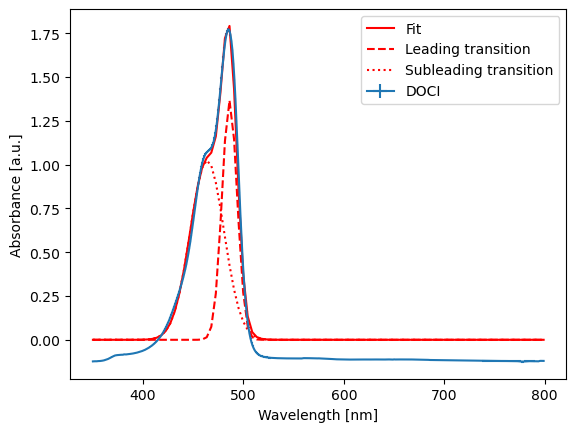

/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


,mu_d,sigma_d,A_d,mu_s,sigma_s,A_s,y_0
DOCI,486.11+/-0.24,7.54+/-0.32,1.37+/-0.06,463.8+/-0.9,16.8+/-0.5,1.025+/-0.022,0.0+/-0


In [6]:
s = spectrums['DOCI'] = CnSpectrum('DOCI', 'data/cianinas_oxo/DO-CI.Sample.Raw.asc', from_inifta=True, x_range=(420, 510))
s.fit(initial_mu_d=490, initial_sigma_d=10, initial_a0_d=1.4, initial_mu_s=460, initial_sigma_s=20, initial_a0_s=1.0, fix_y0=True)
s.plot(x_range=(350, 800))
s.get_fit_params_df()

Fit stop: ['Sum of squares convergence']


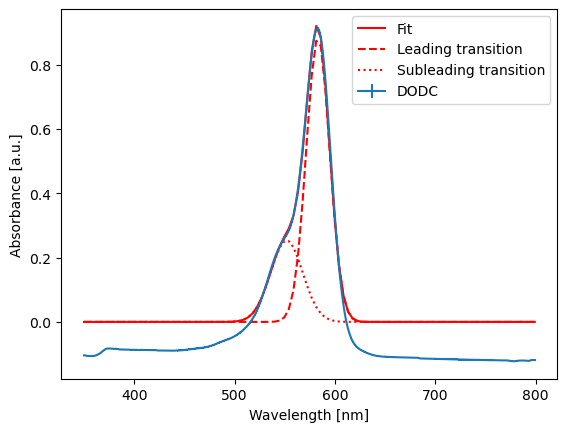

/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


,mu_d,sigma_d,A_d,mu_s,sigma_s,A_s,y_0
DODC,583.01+/-0.17,11.65+/-0.11,0.884+/-0.009,551.8+/-0.8,16.0+/-0.5,0.254+/-0.004,0.0+/-0


In [7]:
s = spectrums['DODC'] =CnSpectrum('DODC', 'data/cianinas_oxo/DO-DS.Sample.Raw.asc', from_inifta=True, x_range=(520, 610))
s.fit(initial_mu_d=580, initial_sigma_d=11, initial_a0_d=1.0, initial_mu_s=560, initial_sigma_s=50, initial_a0_s=0.5, fix_y0=True)
s.plot(x_range=(350, 800))
s.get_fit_params_df()

Fit stop: ['Sum of squares convergence']


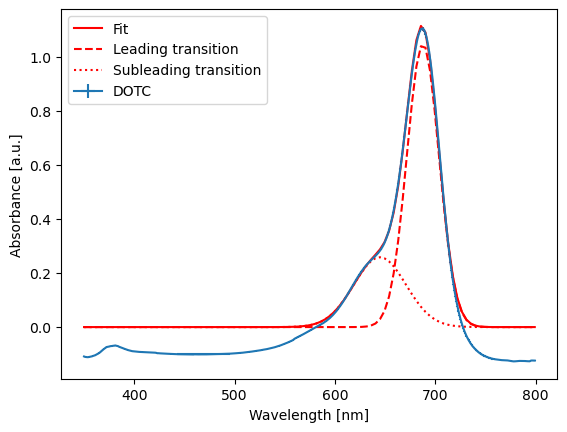

/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


,mu_d,sigma_d,A_d,mu_s,sigma_s,A_s,y_0
DOTC,687.58+/-0.09,15.98+/-0.07,1.046+/-0.007,644.7+/-0.7,26.0+/-0.5,0.2581+/-0.0021,0.0+/-0


In [8]:
s = spectrums['DOTC'] = CnSpectrum('DOTC', 'data/cianinas_oxo/DO-PC.Sample.Raw.asc', from_inifta=True, x_range=(600, 720))
s.fit(initial_mu_d=690, initial_sigma_d=20, initial_a0_d=1.4, initial_mu_s=630, initial_sigma_s=20, initial_a0_s=1.0, fix_y0=True)
s.plot(x_range=(350, 800))
s.get_fit_params_df()

Fit stop: ['Sum of squares convergence']


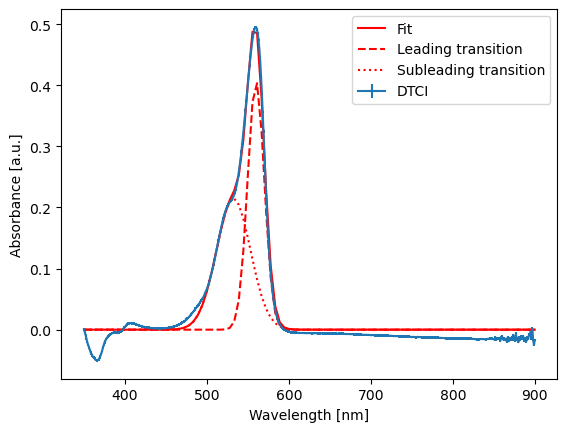

/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


,mu_d,sigma_d,A_d,mu_s,sigma_s,A_s,y_0
DTCI,559.80+/-0.11,10.16+/-0.21,0.407+/-0.015,532.4+/-1.3,20.8+/-0.9,0.2145+/-0.0035,0.0+/-0


In [9]:
s = spectrums['DTCI'] = CnSpectrum('DTCI', 'data/cianinas_tia/File_250827_160523.txt', x_range=(500, 580))
s.fit(initial_mu_d=560, initial_sigma_d=15, initial_a0_d=0.5, initial_mu_s=520, initial_sigma_s=20, initial_a0_s=0.1, fix_y0=True)
s.plot()
s.get_fit_params_df()

Fit stop: ['Sum of squares convergence']


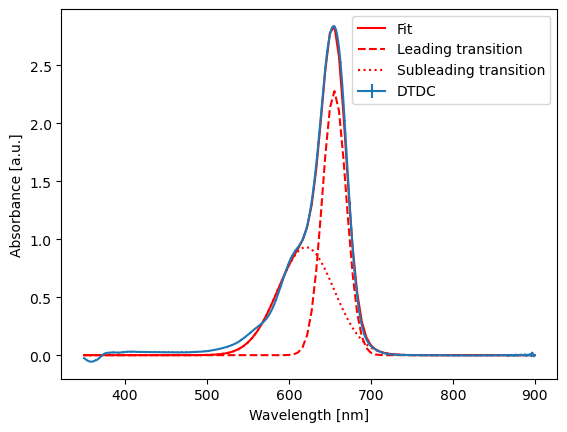

/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


,mu_d,sigma_d,A_d,mu_s,sigma_s,A_s,y_0
DTDC,655.33+/-0.17,14.59+/-0.24,2.277+/-0.035,620.9+/-1.1,34.3+/-0.5,0.931+/-0.016,0.0+/-0


In [10]:
s = spectrums['DTDC'] = CnSpectrum('DTDC', 'data/cianinas_tia/File_250827_161311.txt', x_range=(550, 700))
s.fit(initial_mu_d=655, initial_sigma_d=15, initial_a0_d=2.4, initial_mu_s=620, initial_sigma_s=30, initial_a0_s=0.8, fix_y0=True)
s.plot(save='output/DTDC_fit.pdf')
s.get_fit_params_df()

Fit stop: ['Sum of squares convergence']


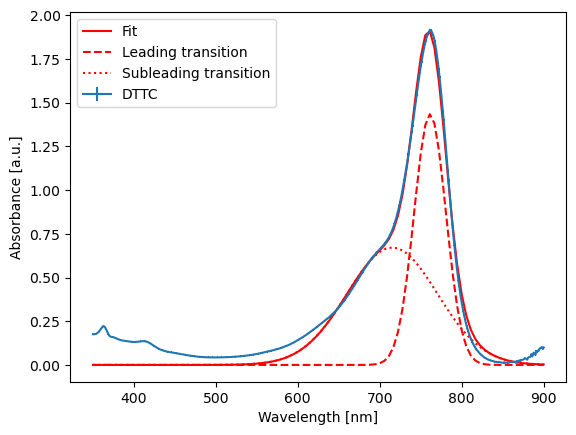

/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


,mu_d,sigma_d,A_d,mu_s,sigma_s,A_s,y_0
DTTC,761.37+/-0.19,19.41+/-0.32,1.434+/-0.026,715.3+/-2.0,55.1+/-1.2,0.671+/-0.009,0.0+/-0


In [11]:
s = spectrums['DTTC'] = CnSpectrum('DTTC', 'data/cianinas_tia/File_250827_163657.txt', x_range=(630, 800))
s.fit(fix_y0=True)
s.plot()
s.get_fit_params_df()

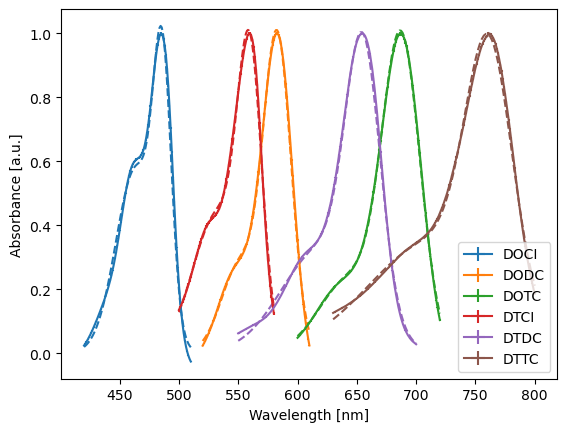

/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


,mu_d,sigma_d,A_d,mu_s,sigma_s,A_s,y_0
DOCI,486.11+/-0.24,7.54+/-0.32,1.37+/-0.06,463.8+/-0.9,16.8+/-0.5,1.025+/-0.022,0.0+/-0
DODC,583.01+/-0.17,11.65+/-0.11,0.884+/-0.009,551.8+/-0.8,16.0+/-0.5,0.254+/-0.004,0.0+/-0
DOTC,687.58+/-0.09,15.98+/-0.07,1.046+/-0.007,644.7+/-0.7,26.0+/-0.5,0.2581+/-0.0021,0.0+/-0
DTCI,559.80+/-0.11,10.16+/-0.21,0.407+/-0.015,532.4+/-1.3,20.8+/-0.9,0.2145+/-0.0035,0.0+/-0
DTDC,655.33+/-0.17,14.59+/-0.24,2.277+/-0.035,620.9+/-1.1,34.3+/-0.5,0.931+/-0.016,0.0+/-0
DTTC,761.37+/-0.19,19.41+/-0.32,1.434+/-0.026,715.3+/-2.0,55.1+/-1.2,0.671+/-0.009,0.0+/-0


In [12]:
plot_all_spectrums(spectrums.values(), plot_fits=True, apply_show_masks=True, norm_to_max=True, save='output/all_spectrums.pdf')
get_all_params(spectrums.values(), mu_only=False)

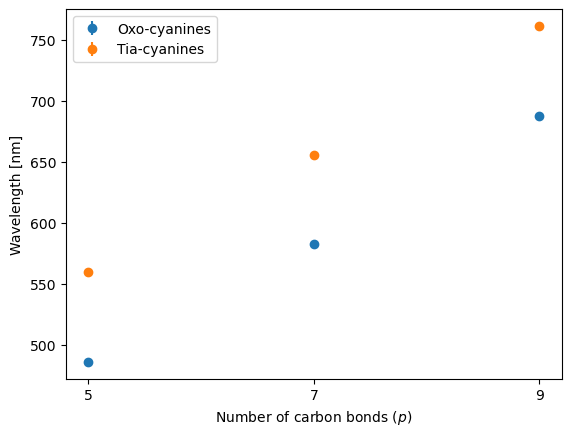

In [13]:
def plot_all(solutions: dict[str, dict[int, float]] | None = None, legend_outside: bool = False, y_range: tuple[float, float] | None = None, save: str | None = None):
    chain_lengths = [5, 7, 9]
    oxo = [spectrums['DOCI'].mu_d, spectrums['DODC'].mu_d, spectrums['DOTC'].mu_d]
    tia = [spectrums['DTCI'].mu_d, spectrums['DTDC'].mu_d, spectrums['DTTC'].mu_d]

    plt.errorbar(chain_lengths, [v.n for v in oxo], yerr=[v.s for v in oxo], label='Oxo-cyanines', linestyle='None', fmt='o')
    plt.errorbar(chain_lengths, [v.n for v in tia], yerr=[v.s for v in tia], label='Tia-cyanines', linestyle='None', fmt='o')

    if solutions is not None:
        for name, values in solutions.items():
            xs = list(values.keys())
            ys = list(values.values())

            plt.plot(xs, ys, marker='x', label=name, linestyle='None', zorder=100)

    if legend_outside:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend()

    plt.xticks(ticks=chain_lengths, labels=chain_lengths)

    plt.xlabel('Number of carbon bonds ($p$)')
    plt.ylabel('Wavelength [nm]')

    if y_range is not None:
        plt.ylim(y_range)

    if save:
        plt.savefig(save)

    plt.show()


plot_all()

In [14]:
# Dict of number of carbon chains for each series
spectrums_per_p = {
    'Oxo': {
        5: spectrums['DOCI'],
        7: spectrums['DODC'],
        9: spectrums['DOTC'],
    },
    'Tia': {
        5: spectrums['DTCI'],
        7: spectrums['DTDC'],
        9: spectrums['DTTC'],
    }
}

In [15]:
def get_chain_length(p: int) -> float:
    '''Get chain length in nm from the number of C-C links'''
    l_cc = 0.134 # [nm], length of C-C links
    return (p+2) * l_cc

def get_homo_e(energies: list[float], p: int) -> float:
    '''Get the HOMO (Highest Occupied Molecular Orbital) energy from the list of energy levels'''
    n_electrons = p + 3
    if len(energies) < n_electrons / 2: return np.nan
    return sorted(energies)[(n_electrons // 2) - 1]

def get_lumo_e(energies: list[float], p: int) -> float:
    '''Get the LUMO (Lowest Unoccupied Molecular Orbital) energy from the list of energy levels'''
    n_electrons = p + 3
    if len(energies) < n_electrons / 2 + 1: return np.nan
    return sorted(energies)[(n_electrons // 2 + 1) - 1]

def get_homo_lumo_transition(energies: list[float], p: int) -> float:
    '''Get the HOMO-LUMO transition energy from the list of energy levels'''
    return get_lumo_e(energies, p) - get_homo_e(energies, p)

# Infinite square well model

The 1-dimensional infinite square well solutions have energies given by

$$E_n = \frac{n^2 \pi^2 \bar{h}^2}{2 m_e L}.$$

It cannot take into account the specifics about the cyanine type

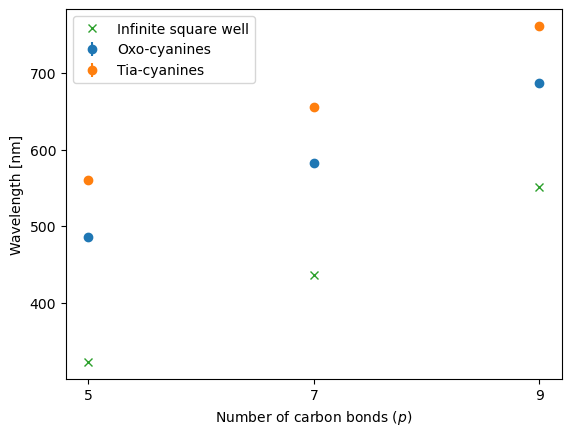

In [16]:
def get_infinite_well_e(n: int, l: float) -> float:
    '''
    Get the n-th energy level for the 1D infinite potential well.

    Energies are in eV, and lengths are in nm.
    '''
    return n**2 * np.pi**2 * hbar**2 / (2 * m_e * (l * 1e-9)**2)

def get_infinite_well_homo_lumo_transition(p: int) -> float:
    '''Get the HOMO-LUMO transition energy for the 1D infinite potential well'''
    n_electrons = p + 3
    return get_infinite_well_e(n_electrons // 2 + 1, get_chain_length(p)) - get_infinite_well_e(n_electrons // 2, get_chain_length(p))

infinite_well_transitions = {
    p: swap_ev_and_nm(get_infinite_well_homo_lumo_transition(p))
    for p in [5, 7, 9]
}

plot_all({'Infinite square well': infinite_well_transitions})

# Finite square well model

As seen in class, the energies of the bound eigenstates of the 1-dimensional finite square well are found by solving the following equations, for the even and odd states respectively:

$$\tan(\theta) = \sqrt{\frac{\theta_0^2}{\theta^2} - 1} \quad \quad \text{(even)},$$
$$-\cot(\theta) = \sqrt{\frac{\theta_0^2}{\theta^2} - 1} \quad \quad \text{(odd)},$$

where

$$\theta(E, L) = k(E) \cdot \frac{L}{2} = \frac{\sqrt{2 m_e E}}{\bar{h}} \cdot \frac{L}{2}$$

in terms of the wavenumber $k$, and $\theta_0 = \theta(V_0, L)$.

In [17]:
def get_fsw_k(e: float) -> float:
    '''Energy in eV'''
    return np.sqrt(2 * m_e * e) / hbar

def get_fsw_theta(e: float, l: float) -> float:
    return get_fsw_k(e) * (l * 1e-9 / 2)

def get_fsw_energy(theta: float, l: float) -> float:
    '''Invert the theta definition'''
    return 2 * hbar**2 * theta**2 / (m_e * (l * 1e-9)**2)

def negative_to_nan(v: float | np.ndarray) -> float | np.ndarray:
    '''
    Turn negative values to np.nan.
    
    Implementing it this way significantly speeds up the numeric methods
    vs vectorizing a single function.
    '''
    if isinstance(v, float):
        return np.nan if v < 0 else v
    elif isinstance(v, np.ndarray):
        arr = v.copy()
        arr[arr < 0] = np.nan
        return arr
    
    raise TypeError('Input must be a float or a numpy array')

def fsw_even_fn(x: float | np.ndarray) -> float | np.ndarray:
    return negative_to_nan(np.tan(x))

def fsw_odd_fn(x: float | np.ndarray) -> float | np.ndarray:
    return negative_to_nan(-1/np.tan(x))

def fsw_g(theta: float, theta0: float) -> float:
    return np.sqrt((theta0 / theta)**2 - 1)

In [18]:
def find_all_roots(f, x_min: float, x_max: float, step: float | None = None, n_steps: int | None = None) -> list[float]:
    '''
    Use a sliding window approach to find all roots of the function f in the interval [x_min, x_max].
    '''
    if step and n_steps:
        raise ValueError('Cannot specify both step and n_steps')
    if not step:
        if not n_steps: n_steps = 1000
        step = (x_max - x_min)/n_steps
    xs = np.arange(x_min, x_max, step)

    roots = []
    for x1, x2 in zip(xs[:-1], xs[1:]):
        y1, y2 = f(x1), f(x2)
        
        # Check if function crosses zero in [x1, x2]
        if y1 == 0:
            # Exact zero at grid point
            roots.append(x1)
        elif y2 == 0:
            # Exact zero at grid point
            roots.append(x2)
        elif y1 * y2 < 0:
            # There is a root within the open interval
            try:
                # We'll find it with brentq
                roots.append(opt.brentq(f, x1, x2))
            except ValueError:
                # No root despite sign change (rare, numerical issue)
                pass

    # Round roots to overcome limits in the numerical precision,
    # and remove duplicates
    return np.unique(np.round(roots, 12))

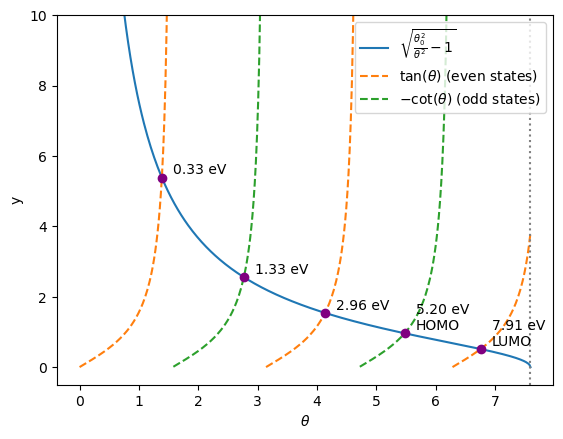

In [19]:
def get_cyanines_fsw_bound_states(v0: float, p: int) -> tuple[list[float], list[float]]:
    '''
    Solve the finite square well equation numerically, and get the bound states' energy levels.

    @param v0: Depth of the well in eV.
    @param p: Number of C-C links in the cyanine chain.

    @return: A tuple with two lists, the first one containing the even states' theta values, and the second one the odd states' theta values.
    '''
    theta0 = get_fsw_theta(e=v0, l=get_chain_length(p))

    # We want to get the zeros of:
    # Even modes: tan(theta) - g(theta),
    # Odd modes: -cot(theta) - g(theta).

    # First, find the range in which we'll look for intersections between the curves.
    search_min = 1e-4 # Avoid the singularities at 0
    # The maximum number of bound states will be when theta == theta0.
    search_max = theta0

    even_zeros_fn = lambda theta: fsw_even_fn(theta) - fsw_g(theta, theta0)
    even_zeros = find_all_roots(even_zeros_fn, search_min, search_max)

    odd_zeros_fn = lambda theta: fsw_odd_fn(theta) - fsw_g(theta, theta0)
    odd_zeros = find_all_roots(odd_zeros_fn, search_min, search_max)

    return list(even_zeros), list(odd_zeros)


def get_cyanines_fsw_energies(v0: float, p: int) -> list[float]:
    '''
    Solve the finite square well equation numerically, and get the bound states' energy levels.

    @param v0: Depth of the well in eV.
    @param p: Number of C-C links in the cyanine chain.

    @return: A list with all bound states' energy levels in eV.
    '''

    even_states, odd_states = get_cyanines_fsw_bound_states(v0, p)
    return sorted(get_fsw_energy(np.array(even_states + odd_states), get_chain_length(p)))


def plot_cyanines_fsw_bound_states(v0: float = 10, p: int = 5, save: str | None = None):
    '''
    Solve the finite square well equation graphically, and get the bound states' energy levels.

    @param v0: Depth of the well in eV.
    @param p: Number of C-C links in the cyanine chain.
    @param save: If specified, save the plot to this file.
    '''
    l = get_chain_length(p)
    theta0 = get_fsw_theta(e=v0, l=l)

    # X-axis values
    theta = np.linspace(0.001, theta0, 400)

    # Clear the previous plot (in case we're using an interactive backend)
    plt.cla()

    # Draw the function
    plt.plot(theta, fsw_g(theta, theta0), label=r'$\sqrt{\frac{\theta_0^2}{\theta^2}-1}$')
    plt.plot(theta, fsw_even_fn(theta), label=r'$\tan(\theta)$ (even states)', linestyle='--')
    plt.plot(theta, fsw_odd_fn(theta), label=r'$-\cot(\theta)$ (odd states)', linestyle='--')

    plt.axvline(theta0, linestyle=':', color='gray')
    plt.xlabel(r'$\theta$')
    plt.ylabel('y')
    plt.ylim(-0.5, 10)

    plt.legend(loc='upper right')


    # Now solve the equation numerically
    even_solutions, odd_solutions = get_cyanines_fsw_bound_states(v0, p)

    energies = get_fsw_energy(np.array(even_solutions + odd_solutions), l)
    homo_e = get_homo_e(energies, p)
    lumo_e = get_lumo_e(energies, p)

    def process_solutions(solutions: list[float], fn) -> tuple[list[float], list[float]]:
        x_lst = []
        y_lst = []
        for x in solutions:
            if x is np.nan: continue
            y = fn(x)

            x_lst.append(x)
            y_lst.append(y)

            if y > 10: continue

            e = get_fsw_energy(x, get_chain_length(p))

            sfx = ''
            if homo_e != np.nan and round(e - homo_e, 5) == 0: sfx = '\nHOMO'
            elif lumo_e != np.nan and round(e - lumo_e, 5) == 0: sfx = '\nLUMO'

            plt.text(x + theta0/40, y + 0.1, f'{e:.2f} eV' + sfx, horizontalalignment='left')

        return x_lst, y_lst

    es_x, es_y = process_solutions(even_solutions, fsw_even_fn)
    plt.plot(es_x, es_y, 'o', color='purple', linestyle='None')

    os_x, os_y = process_solutions(odd_solutions, fsw_odd_fn)
    plt.plot(os_x, os_y, 'o', color='purple', linestyle='None')

    if save:
        plt.savefig(save)

    plt.show()

plot_cyanines_fsw_bound_states(v0=10, p=5, save='output/fsw_solutions_v10_p5.pdf')

In [ ]:
# Interactive plot with sliders :)

from ipywidgets import interactive
plot_model_interactive = lambda v0, p: plot_cyanines_fsw_bound_states(v0, p, save=None)
interactive(plot_model_interactive, v0=(0.01, 20.0), p=(1, 10, 1))

interactive(children=(FloatSlider(value=10.004999999999999, description='v0', max=20.0, min=0.01), IntSlider(v…

/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_93047/2927935200.py:35: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((theta0 / theta)**2 - 1)


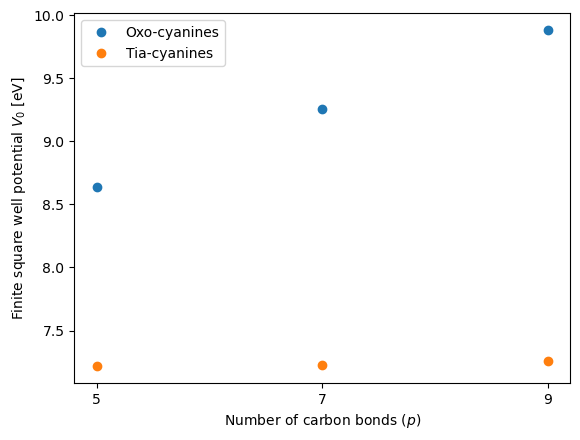

In [21]:
def get_v0_from_homo_lumo_transition(e: float, p: int) -> float:
    '''Get the finite square well potential V0 from the HOMO-LUMO transition energy'''
    
    # Minimize the difference between the experimental observation and the model prediction
    # to get the per-cyanine V0
    def fn(v0: float) -> float:
        model_e = get_homo_lumo_transition(get_cyanines_fsw_energies(v0, p), p)
        return model_e - e

    roots = find_all_roots(fn, 0, 20)
    if len(roots) != 1:
        raise ValueError(f'Did not find a unique solution for {e=} and {p=}')
    
    return roots[0]

# NOTE: This takes ~1m to run, be patient!
oxo_v0s = {
    p: get_v0_from_homo_lumo_transition(swap_ev_and_nm(spectrum.mu_d.n), p)
    for p, spectrum in spectrums_per_p['Oxo'].items()
}

tia_v0s = {
    p: get_v0_from_homo_lumo_transition(swap_ev_and_nm(spectrum.mu_d.n), p)
    for p, spectrum in spectrums_per_p['Tia'].items()
}

plt.plot(oxo_v0s.keys(), oxo_v0s.values(), 'o', label='Oxo-cyanines', linestyle='None')
plt.plot(tia_v0s.keys(), tia_v0s.values(), 'o', label='Tia-cyanines', linestyle='None')

plt.legend()
plt.xlabel('Number of carbon bonds ($p$)')
plt.ylabel('Finite square well potential $V_0$ [eV]')

plt.xticks(ticks=list(oxo_v0s.keys()), labels=list(oxo_v0s.keys()))

plt.savefig('output/fsw_v0s_fit.pdf')

plt.show()

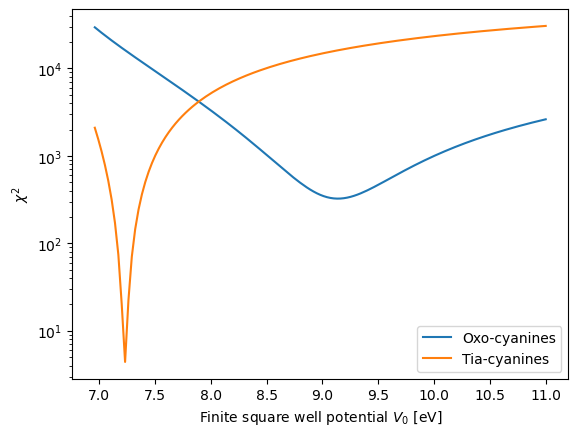

In [22]:
def _fsw_chi2(v0: float, spectrums: dict[int, CnSpectrum]) -> float:
    '''Calculate the chi-squared value for a set of spectra's energies, and the FSW predictions'''
    total = 0

    for p, spectrum in spectrums.items():
        model_e = swap_ev_and_nm(get_homo_lumo_transition(get_cyanines_fsw_energies(v0, p), p))
        total += (spectrum.mu_d.n - model_e) ** 2

    return total

# We need to vectorize this function, so that the libraries can use it over an np.ndarray
fsw_chi2 = np.vectorize(_fsw_chi2, excluded=['spectrums'])


v0s = np.linspace(5, 11, 200)

plt.plot(v0s, fsw_chi2(v0s, spectrums=spectrums_per_p['Oxo']), label='Oxo-cyanines')
plt.plot(v0s, fsw_chi2(v0s, spectrums=spectrums_per_p['Tia']), label='Tia-cyanines')
plt.legend()
plt.xlabel('Finite square well potential $V_0$ [eV]')
plt.ylabel(r'$\chi^2$')
plt.yscale('log')

plt.savefig('output/fsw_chi2.pdf')

plt.show()

Fitting Oxo-cyanines V0
 message: Solution found.
 success: True
  status: 0
     fun: 324.8290603947673
       x: 9.13810913824211
     nit: 14
    nfev: 14
Found V0 = 9.138+/-0.014

Fitting Tia-cyanines V0
 message: Solution found.
 success: True
  status: 0
     fun: 4.357993168870854
       x: 7.229528471947307
     nit: 16
    nfev: 16
Found V0 = 7.230+/-0.004



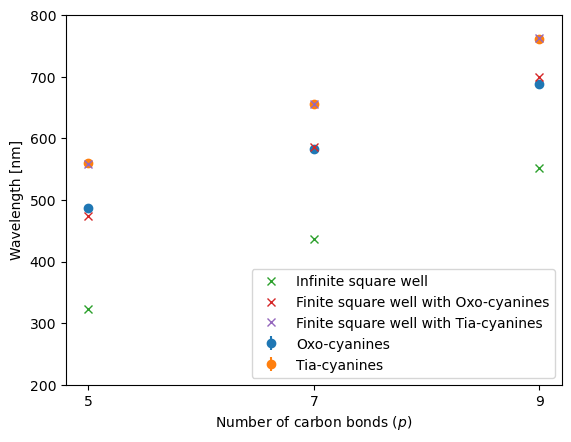

In [23]:
def find_series_v0(spectrums: dict[int, CnSpectrum]) -> float:
    '''Find the common V0 value for a series of spectra, sharing the same radicals'''
    # Minimize fsw_chi2, using the Nelder-Mead solver to overcome precision issues
    roots = opt.minimize_scalar(fsw_chi2, bounds=(1, 20), method='bounded', args=(spectrums))
    print(roots)

    # To get the uncertainty, we will numerically differentiate the chi2 function:
    # We get the covariance matrix from the Hessian
    import numdifftools as nd
    hess = nd.Hessian(partial(fsw_chi2, spectrums=spectrums), step=1e-5)
    cov = 0.5 * np.linalg.inv(hess(roots.x))

    return uncertainties.ufloat(roots.x, cov[0][0]**0.5)


def run_fsw_fit(series: str) -> dict[int, float]:
    print(f'Fitting {series}-cyanines V0')
    v0 = find_series_v0(spectrums_per_p[series])
    print(f'Found V0 = {v0}\n')

    ret = {}
    for p in [5, 7, 9]:
        ret[p] = swap_ev_and_nm(get_homo_lumo_transition(get_cyanines_fsw_energies(v0.n, p), p))

    return ret

plot_all({
    'Infinite square well': infinite_well_transitions,
    'Finite square well with Oxo-cyanines': run_fsw_fit('Oxo'),
    'Finite square well with Tia-cyanines': run_fsw_fit('Tia'),
}, y_range=(200, 800), save='output/all_models.pdf')